In [266]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import square
from scipy.integrate import quad
from numpy import sqrt, exp, pi, cos, sin, log
from scipy.stats import norm, expon, lognorm
import pandas as pd
from time import perf_counter
from tqdm  import tqdm
import polars as pl

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')
np.seterr(all = 'ignore')

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [327]:
# Global color shades
blue_shades     = ['#0000FF', '#3399FF', '#66B2FF', '#99CCFF', '#CCE5FF']
green_shades    = ['#005500', '#009900', '#00CC00', '#66FF66', '#99FF99']

# Part 1
----------------------------------------------------------------
from Medium.com : https://medium.com/@alexander.tsoskounoglou/pricing-options-with-fourier-series-p1-5bf60443ba0c 

## Introduction
For a function $f(x)$ with for a range a,b we can transform it as:
$$\begin{align*}
& f(x) &\approx& A_0 + \sum_{n=1}^{\infty}A_n*cos\bigg(\frac{2\pi xn}{b-a}\bigg) + B_n*sin\bigg(\frac{2\pi xn}{b-a}\bigg) \\
& A_0  &=& \frac{1}{b-a}\int_{a}^{b} f(x)dx \quad for \; n\ge 1\\
& A_n  &=& \frac{2}{b-a}\int_{a}^{b} f(x)*cos\bigg(\frac{2\pi xn}{b-a}\bigg)dx \quad for \; n\ge 1\\
& B_n  &=& \frac{2}{b-a}\int_{a}^{b} f(x)*sin\bigg(\frac{2\pi xn}{b-a}\bigg)dx \quad for \; n\ge 1\\
\end{align*}$$

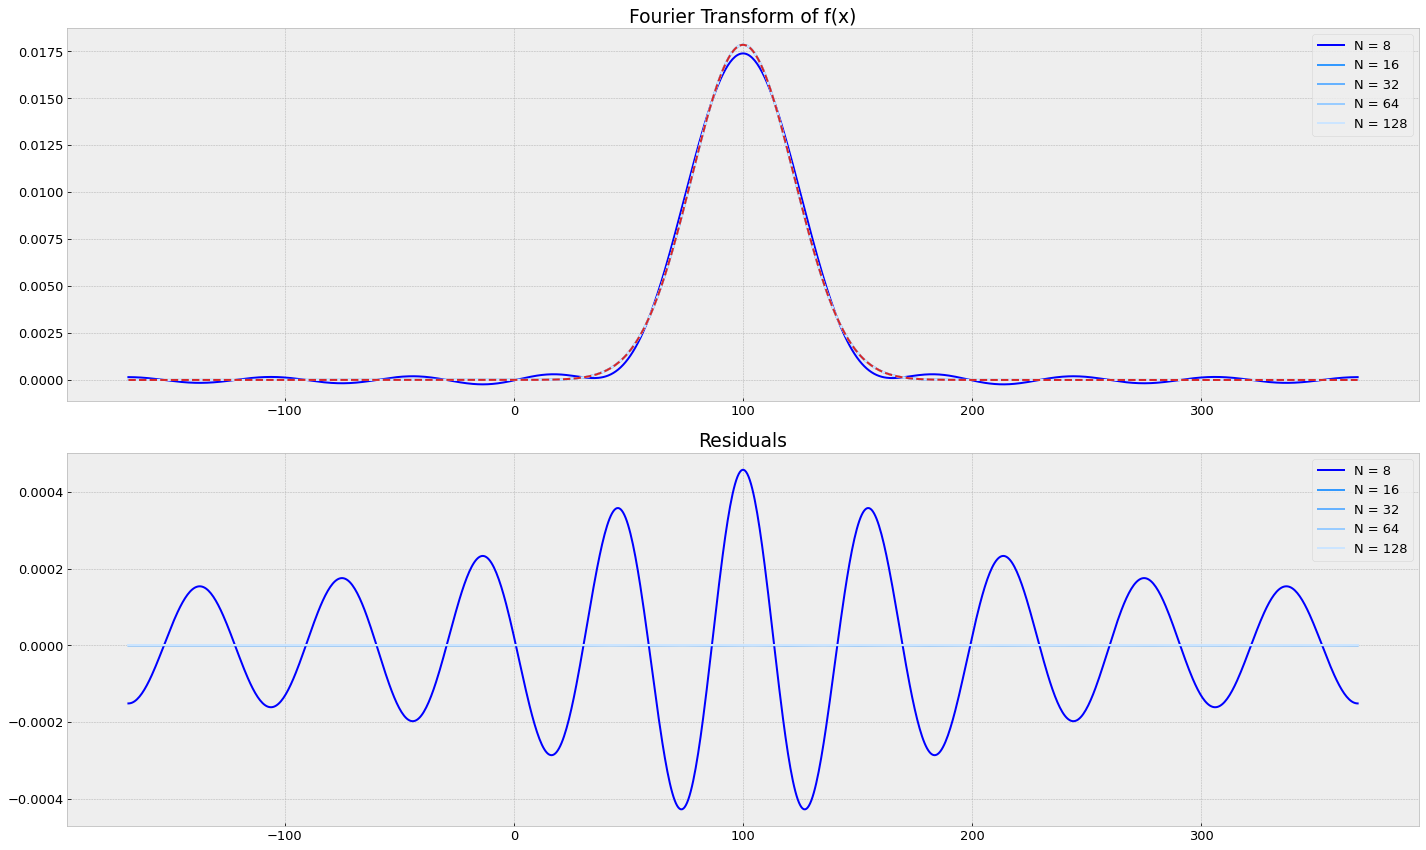

,Avg Residual
8,0.000
16,0.000
32,0.000
64,0.000
128,0.000


In [391]:
def get_fourier_approx(f, x:np.array, a:float, b:float, N:int):
    fa = lambda x, n : f(x) * cos((2*pi*n*x)/(b - a))
    fb = lambda x, n : f(x) * sin((2*pi*n*x)/(b - a))

    A0 = 1/(b - a) * quad(f, a, b, limit=200)[0]

    Cosine_Sine_Sum = np.zeros_like(x)
    for n in range(1, N+1):
        A = 2/(b - a) * quad(fa, a, b, args=(n), limit=200)[0]
        B = 2/(b - a) * quad(fb, a, b, args=(n), limit=200)[0]
        Cosine_Sine_Sum += A*cos((2*pi*n*x)/(b - a)) + B*sin((2*pi*n*x)/(b - a))

    fx = A0 + Cosine_Sine_Sum
    return fx


mean = 100
std  = .1 *sqrt(5)*100 
f = lambda x : (1/(std*sqrt(2*pi))) * exp(-(x-mean)**2/(2*std**2)) #*12/0.0175
# f = lambda x : square(x)*6
# f = lambda x : x

a = mean - 12 * std
b = mean + 12 * std

# a = -6
# b = 6

x = np.linspace(a, b, 1_000)
y = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,y-fx, blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y-fx).mean())

ax1.set_title('Fourier Transform of f(x)')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend();ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

In [ ]:
Avg Residual
N   Square f   Line f      Normal Distribution
8	1.311711   0.447389    1.593045e-04
16	0.784683   0.264635    1.214211e-07
32	0.440387   0.153540    7.100142e-18
64	0.268449   0.088745    3.628299e-14
128	0.154604   0.052147    2.992953e-12

## Log normal distribution of $S_t$
$$\begin{align*}
& N(z)   &=\;& \frac{1}{\sqrt{2\pi}} exp\bigg\{-\frac{z^2}{\sigma^2}\bigg\} & \\
& S_T(z) &=\;& S_0 exp\bigg\{(r-\frac{1}{2}\sigma^2)T + \sigma\sqrt{T}z \bigg\} & = S_T\\
& S_T^{-1}(S_T) &=\;& \frac{log(\frac{S_T}{S_0})-(r-\frac{1}{2}\sigma^2)T}{\sqrt T \sigma} & = z\;\;\\
& \mathbb{P}[S_T|S_0] &=\;& N(S_T^{-1}(S_T)) &\\
& a &=\;& S_T(-12) &\\
& b &=\;& S_T(12) &\\
\end{align*}$$

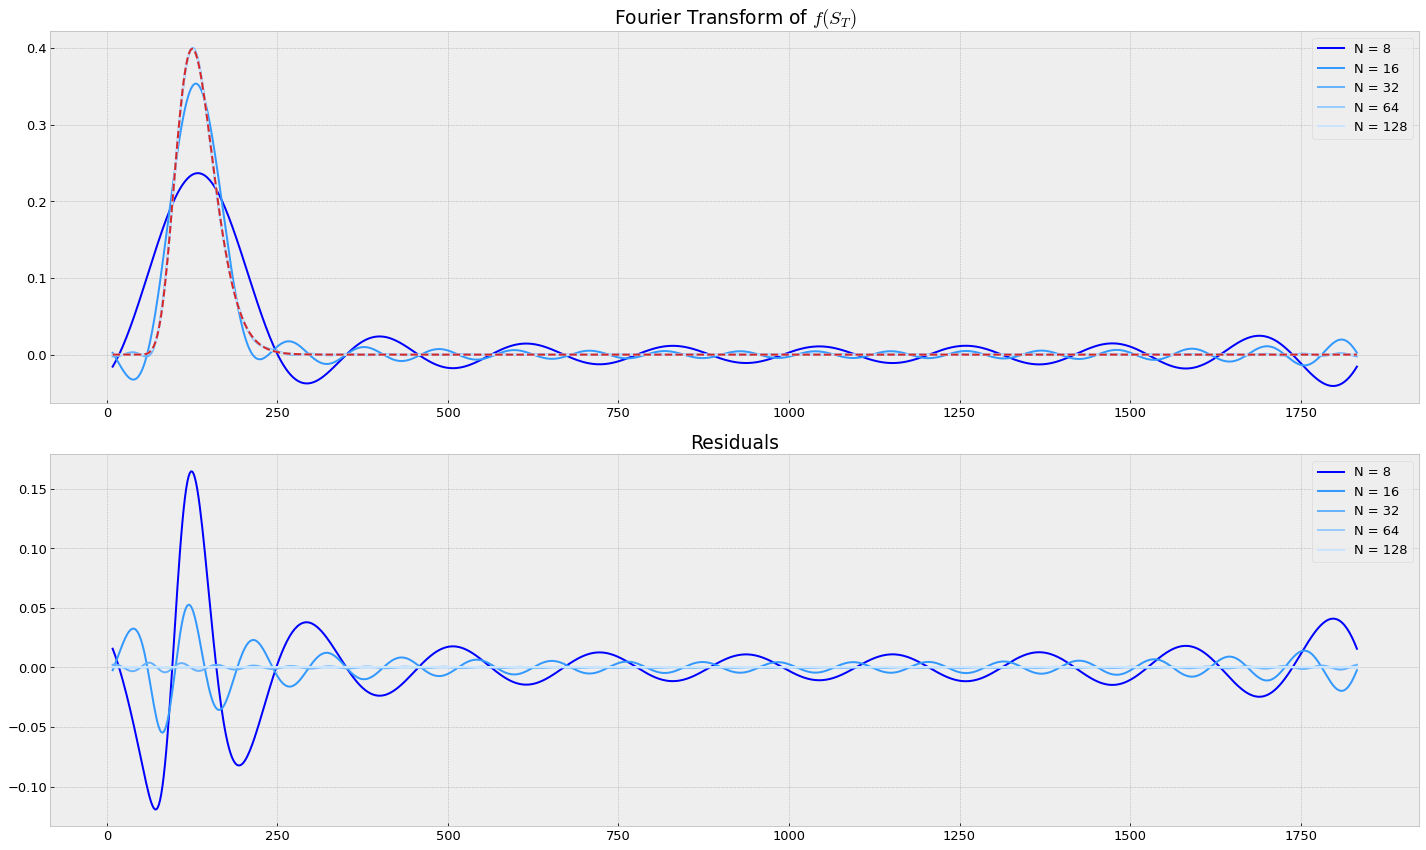

,Avg Residual
8,1.897794e-02
16,7.159815e-03
32,5.616416e-04
64,2.326956e-06
128,1.384069e-10


In [268]:
def get_fourier_approx(f, x:np.array, a, b, N:int):
    limit = 1000
    L = b - a
    upper = b
    lower = a 
    # print(f"L = {L} \nupper = {upper} \nlower = {lower}")

    fa = lambda x, n : f(x) * cos((2*pi*n*x)/(L))
    fb = lambda x, n : f(x) * sin((2*pi*n*x)/(L))

    A0 = (1/L) * quad(f, lower, upper, limit=limit)[0]

    Cosine_Sine_Sum = np.zeros_like(x)
    for n in range(1, N+1):
        A = (2/L) * quad(fa, lower, upper, args=(n), limit=limit)[0]
        B = (2/L) * quad(fb, lower, upper, args=(n), limit=limit)[0]
        Cosine_Sine_Sum += A*cos((2*pi*n*x)/(L)) + B*sin((2*pi*n*x)/(L))

    fx = A0 + Cosine_Sine_Sum
    return fx


S0      = 100
K       = 100
r       = 0.05
sigma   = 0.1
T       = 5.0

S_T     = lambda z : S0*exp((r-.5*sigma**2)*T + sigma*sqrt(T)*z)
S_T_inv = lambda S_T : (log(S0/S_T) + (r - .5*sigma**2)*T)/(sqrt(T)*sigma)
f       = lambda S_T : norm.pdf(S_T_inv(S_T)) # P[S_T = X]


a   = S_T(-12)
b   = S_T(12)
x   = np.linspace(a, b, 1_000)
y   = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,(y-fx), blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y-fx).mean())

ax1.set_title(r'Fourier Transform of $f(S_T)$')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

## Timeings

In [ ]:
x = np.array([100.0])
Ns = [8, 16, 32, 64, 128]
timings = []
for i, N in tqdm(enumerate(Ns), total=5):
    avg_time = []
    for _ in range(10):
        t = perf_counter()
        _ = get_fourier_approx(f=f, x=x, a=a, b=b, N=N)
        avg_time.append(perf_counter() - t)
    timings.append(np.mean(avg_time))

pd.DataFrame(timings, index=Ns, columns=['Execution Time'])

In [270]:
"""
N       Avg. (scaled) Residual      Avg. Residual       Execution Time (sec)
----------------------------------------------------------------------------
8	    0.176429                    5.880975e-03        0.112720 
16	    0.004235                    1.411566e-04        0.246473 
32	    0.000030 	                9.855127e-07        0.624209 
64	    0.000027 	                8.918504e-07        1.936948 
128	    0.000026 	                8.530034e-07        6.741019
""" ; 

# Part 2
--------------------------------------
## Fourier cosine expansion

The Fourier-cosine expansion theorem states that any integrable function f on an interval
[a, b] can be written as an infinite sum of cosine functions, since:

$$\begin{align*}
&f(x) &=& \frac{1}{2}A_0 + \sum_{n=1}^{\infty}A_n cos(n\pi\frac{x-a}{b-a}) \\
&A_n &=& \frac{2}{b-a}\int_a^bf(x)cos(n\pi\frac{x-a}{b-a})dx \\
\end{align*}$$

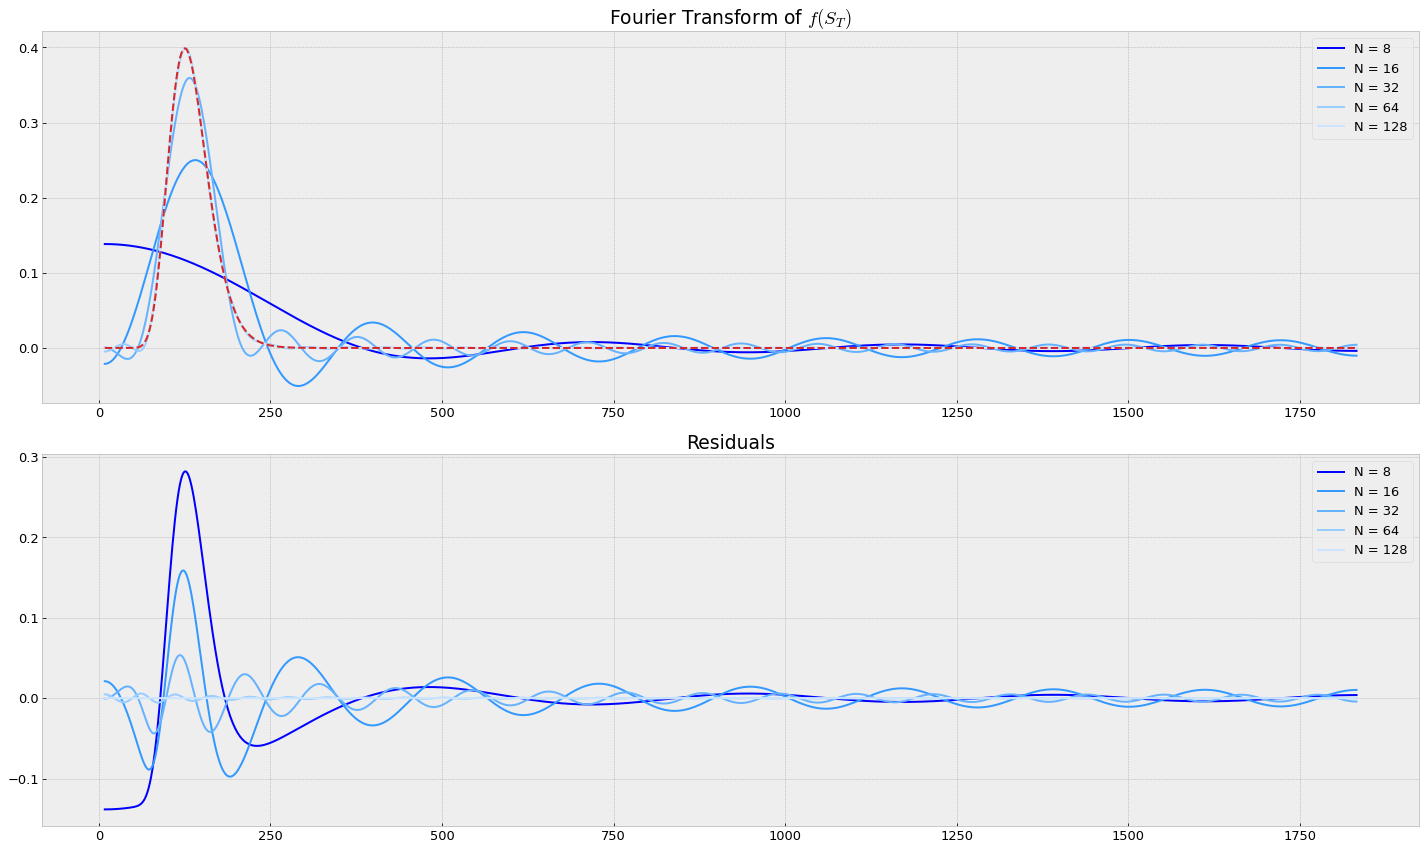

,Avg Residual
8,0.020561
16,0.018211
32,0.006961
64,0.000559
128,0.000003


In [271]:
def Fourier_cosine(f, x:np.array, a, b, N:int):
    ql = 1000 # quad_limit

    fa = lambda x, n : f(x) * cos(n*pi * (x-a)/(b-a))
    A  = lambda x, n : 2/(b-a) * quad(fa, a, b, limit=ql, args=(n))[0] * cos(n*pi * (x-a)/(b-a))

    fx = .5*A(x, 0)
    for n in range(1, N+1):
        fx += A(x, n)
    
    return fx


S0      = 100
K       = 100
r       = 0.05
sigma   = 0.1
T       = 5.0

# ----------------------------------------------------------------
S_T     = lambda z : S0*exp((r-.5*sigma**2)*T + sigma*sqrt(T)*z)
S_T_inv = lambda S_T : (log(S0/S_T) + (r - .5*sigma**2)*T)/(sqrt(T)*sigma)
f       = lambda S_T : norm.pdf(S_T_inv(S_T)) # P[S_T = X]


a   = S_T(-12)
b   = S_T(12)
x   = np.linspace(a, b, 1_000)
y   = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

avg_residuals = []
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = Fourier_cosine(f=f, x=x, a=x[0], b=x[-1], N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,(y-fx), blue_shades[i], label=f'N = {N}')
    avg_residuals.append(np.abs(y-fx).mean())

ax1.set_title(r'Fourier Transform of $f(S_T)$')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame(avg_residuals, index=Ns, columns=['Avg Residual'])

## Approximating the $A_n$ terms using the characteristic function and analytically solving the integral

### Step 1 : Euler's Formula to transform $\cos(x)$
$$\begin{align*}
& e^{ix} &=\;& \cos(x) + \sin(x) & \\
\Rightarrow \quad & \cos(x) &=\;& e^{ix} \quad &
\text{, Since $sin(x)=0$ in the cosine transform} \\
\Rightarrow \quad & \cos(n\pi\frac{x-a}{b-a}) &=\;& e^{in\pi\frac{x-a}{b-a}} \\
\\
\Rightarrow \quad & A_n &=& \frac{2}{b-a}\int_a^bf(x)\cos(n\pi\frac{x-a}{b-a})dx \\
                  &  &=& \frac{2}{b-a} Re\bigg[\int_a^bf(x)e^{in\pi\frac{x-a}{b-a}}dx\bigg] \\
\end{align*}$$

### Step 2 : Characteristic function of $f(x)$
In probability theory, a characteristic function is a complex-valued function defined for a random variable. It captures the moments and distributional properties of the random variable, allowing for the analysis of various statistical properties using techniques such as Fourier transforms. For example for a random noraml variable:
$$\begin{align*}
& \varphi_X(u) &=\;& \mathbb{E}\big[ e^{iuX}\big] & u \in \R \\
& \varphi_X(u) &=\;& e^{iu\mu-\frac{1}{2}\sigma^2u^2} & \quad\text{If $X \sim N(\mu,\sigma^2)$} \\
& \varphi_X(u) &=\;& e^{\lambda(e^{iu-1})} & \quad\text{If $X \sim Poisson(\lambda)$} \\
\end{align*}$$


In our use case we can transform the density function of i.e. $log(S_T)$. Bellow $f$ is the density of a random variable $Z$ with a known characteristic function $\varphi_Z(u)$. For example if $Z$ is a random normal variable we can use the equation above:

$$\begin{align*}
\\
& \int_a^bf(z)e^{in\pi\frac{z-a}{b-a}}dz = \int_a^bf(z)e^{in\pi\frac{z}{b-a}}e^{in\pi\frac{a}{b-a}}dz = e^{in\pi\frac{-a}{b-a}}\int_a^bf(z)e^{in\pi\frac{z}{b-a}}dz \\
\\
Since, \quad & \int_a^bf(z)e^{in\pi\frac{z}{b-a}}dz = \mathbb{E}\big[ e^{in\pi\frac{z}{b-a}}\big] \\
\Rightarrow \quad & \int_a^bf(z)e^{in\pi\frac{z-a}{b-a}}dz = \mathbb{E}\big[ e^{in\pi\frac{z}{b-a}}\big]e^{in\pi\frac{-a}{b-a}} \\
\\
Since, \quad &  \varphi_z(1) =  \mathbb{E}\big[ e^{iz}\big]  \\
\Rightarrow \quad & \varphi_z(\frac{n\pi}{b-a}) = \mathbb{E}\big[ e^{in\pi\frac{z}{b-a}}\big] \\
\\
\end{align*}$$
Therefore,
$$\begin{align*}
A_n &=\;&\frac{2}{b-a}Re\bigg[ \mathbb{E}\big[ e^{in\pi\frac{z}{b-a}}\big] e^{in\pi\frac{-a}{b-a}} \bigg] + E_n \\
    &=\;& \frac{2}{b-a}Re\bigg[ \varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} \bigg] + E_n \\
\end{align*}$$
Where $E_n$ is the part of the integral outside of $[a,b]$ which is very small if for probability mass $f(x)$ we pick $a,b$ where $f(x)$ is close to zero. Similar concept can be applied if $f(x)$ is the payoff of an option and the payoff is very small for $a,b$

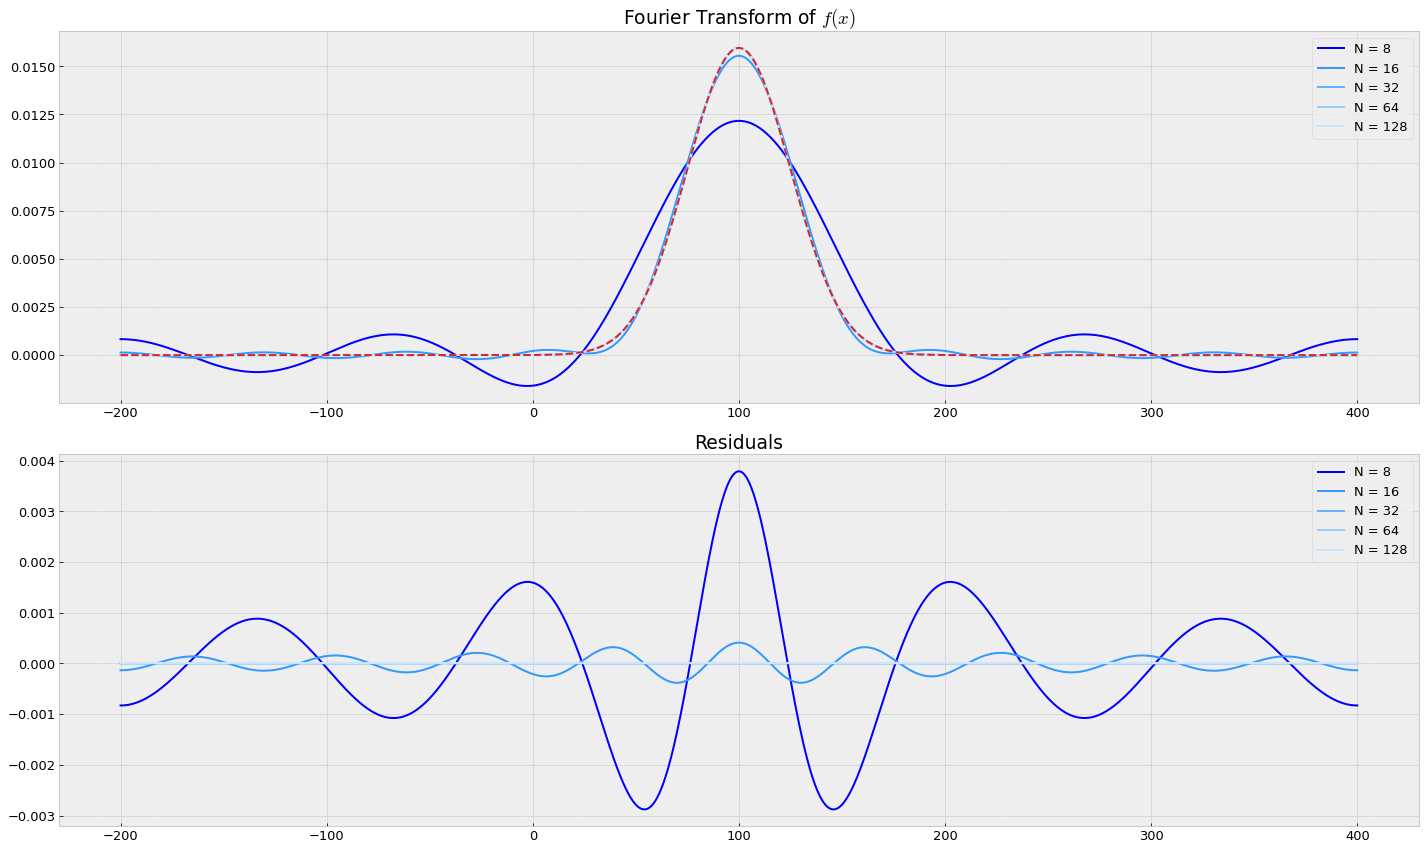

,avg_residuals,Ex. Time
N,,
8,1.182498e-03,0.000059
16,1.588727e-04,0.000092
32,1.160981e-07,0.000180
64,2.983220e-18,0.000358
128,2.986019e-18,0.000767


In [272]:
def Fourier_cosine_char_function(char_function, x:np.array, a, b, N:int):

    A  = lambda n : 2/(b-a) * np.real( char_function((n*pi)/(b-a))*exp((-1j*n*pi*a)/(b-a))  )
    fx = .5*A(0)
    for n in range(1, N+1):
        fx += A(n) * cos(n*pi * (x-a)/(b-a))
    
    return fx

# --------------------------------------------------------------------------------------------------------------------------------

S0      = 100
K       = 100
r       = 0.05
sigma   = 0.1
T       = 5.0

# For normal distribution 
mu      = 100
sigma   = 25
char_function = lambda u: exp(1j*u*mu -.5*sigma**2*u**2)
f             = lambda x: norm.pdf(x, loc=mu, scale=sigma)

a   = 100 - 12 * sigma
b   = 100 + 12 * sigma

# # For Exonential distribution 
# l = 1
# char_function = lambda u: l/(l - 1j*u)
# f             = lambda x: expon.pdf(x)

# a   = 0
# b   = l + 12 * (1/l)

# --------------------------------------------------------------------------------------------------------------------------------
x   = np.linspace(a, b, 1_000)
y   = f(x)

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

results = {'N': [], 'avg_residuals': [] , 'Ex. Time' : []}
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = Fourier_cosine_char_function(char_function=char_function, x=x, a=a, b=b, N=N)
    ex_time = []
    for _ in range(15):
        timer =perf_counter()
        _ = Fourier_cosine_char_function(char_function=char_function, x=np.array([100]), a=a, b=b, N=N)
        timer = perf_counter() - timer ; ex_time.append(timer)
    
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,(y-fx), blue_shades[i], label=f'N = {N}')
    results['N'].append(N)
    results['avg_residuals'].append(np.abs(y-fx).mean())
    results['Ex. Time'].append(np.mean(ex_time))

ax1.set_title(r'Fourier Transform of $f(x)$')
ax1.plot(x,y,'tab:red', linestyle='--')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame.from_dict(results).set_index('N')

## Option pricing using Fourier series
### Recap
For a function $f$ where it represents the density function of a random variable $z$ we have the Fourier cosine expansion:
$$\begin{align*}
f(z) &\approx& \frac{1}{2}A_0 + \sum_{n=1}^{\infty}A_n cos(n\pi\frac{z-a}{b-a}) \\
A_n     &=\;& \frac{2}{b-a}Re\bigg[ \varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} \bigg] 
\end{align*}$$

Lets rearange the terms and substitute $A_n$:
$$\begin{align*}
f(z) &\approx& \varphi_z(0) + \sum_{n=1}^{N} 2\varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} \cos(n\pi\frac{z-a}{b-a})
\end{align*}$$

### Characteristic function of the density of future asset prices
Where $f = f_\mathbb{Q}^{log}(t, S_t, \sigma_{implied}, T, z) $ is the density of future asset prices and has characteristic function $\varphi$. Note that $z = log(S_T)$. \
So we are going to use this new tool to price a derivative $F$ whith defined payoff $F(T, S_T)$:

$$\begin{align*}
&F(t, S_t, \sigma_{implied}, T) &=\;& e^{-r(T-t)} \int_R F(T, e^z) * f_\mathbb{Q}^{log}(t, S_T, \sigma_{implied}, T, z) dz & \\
& &=\;& e^{-r(T-t)} Re\Bigg[ \int_R F(T, e^z) * \frac{1}{b-a}Re\bigg[\varphi_z(0) + \sum_{n=1}^{N} 2\varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} \cos(n\pi\frac{z-a}{b-a}) \bigg] dz \Bigg]& \\

& &=\;& \frac{e^{-r(T-t)}}{b-a} Re\Bigg[ g_0 + \sum_{n=1}^{N} 2\varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} g_n \Bigg]& \\
\\
&g_n &=\;& \int_a^b F(T, e^Z) \cos(n\pi\frac{z-a}{b-a}) dz\\
\end{align*}$$
\
For a suitably large $N$ usually between $[64, 256]$

### Explicit solution for Put option
Furthermore, since $g_n$ depends only the the payoff function at $T$ we can calculate $g_n$ explicitly. Where for a put option $F(t, e^Z) = (K - e^Z)^+$:
$$\begin{align*}
&g_n &=\;& \int_a^{logK} (K - e^Z) \cos(n\pi\frac{z-a}{b-a}) dz &\\
&&=\;& \frac{e^a - \frac{K}{h_n}\sin(h_n(a-logK)) - K\cos(h_n(a-logK))}{1+h_n^2} & ,\; for \quad n > 0\\
&g_0 &=\;& K(logK - a - 1) +e^a & ,\; for \quad n = 0\\
&h_n &=\;& \frac{n\pi}{b-a} &
\end{align*}$$

<!-- ### Final Solution
$$\begin{align*}
&F(t, S_t, \sigma_{implied}, T) &\approx\;& \frac{e^{-r(T-t)}}{b-a} Re\Bigg[ g_0 + \sum_{n=1}^{N} 2\varphi_z(\frac{n\pi}{b-a}) e^{in\pi\frac{-a}{b-a}} g_n \Bigg]& \\
&g_0 &=\;& K(logK - a - 1) +e^a & \\
&h_n &=\;& \frac{n\pi}{b-a} &
\end{align*}$$ -->

### Black-Scholes Characteristic function
If you recall above the solution to the characteristic function of the normal distribution it will make sense.
$$\begin{align*}
&\varphi(u) &=\;& \mathbb{E}\big[e^{iu\;log(S_T)}|F_t] = e^{ium - \frac{1}{2}u^2\sigma^2(T-t)} \\
& m &=\;& log(S_t) + (r - \delta - \frac{1}{2}\sigma^2)(T-t)
\end{align*}$$



In [273]:
def bs_put(S0, K, T, sigma, r):
    d1 = (log(S0/K) + (r + sigma**2/2.) * T) / (sigma*sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return  K*exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)

def bs_call(S0, K, T, sigma, r):
    d1 = (log(S0/K) + (r + sigma**2/2.) * T) / (sigma*sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    return S0*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)

In [274]:
def Fourier_BS_Put(S0, K, T, sigma, r, N):
    _sigma, _T = max(.1, sigma), max(1, T)
    a = log(S0) + r * _T - 12 * _sigma * np.sqrt(_T) # Upper limit -12 std from the expected value
    b = log(S0) + r * _T + 12 * _sigma * np.sqrt(_T) # Lower limit -12 std from the expected value

    h       = lambda n : (n*pi) / (b-a) 
    g       = lambda n : (exp(a) - (K/h(n))*sin(h(n)*(a - log(K))) - K*cos(h(n)*(a - log(K)))) / (1 + h(n)**2)
    g0      = K*(log(K) - a - 1) + exp(a)
    
    m       = log(S0) + (r - .5*sigma**2)*(T)
    bs_char = lambda u : exp(1j * u * m -0.5*(u**2 * sigma**2)*T)

    F = g0 
    for n in range(1, N+1):
        h_n = h(n)
        F += 2*bs_char(h_n) * exp(-1j*a*h_n) * g(n)

    F = exp((-r*T))/(b-a) * np.real(F)
    return F

## Fourier Series Value Over K

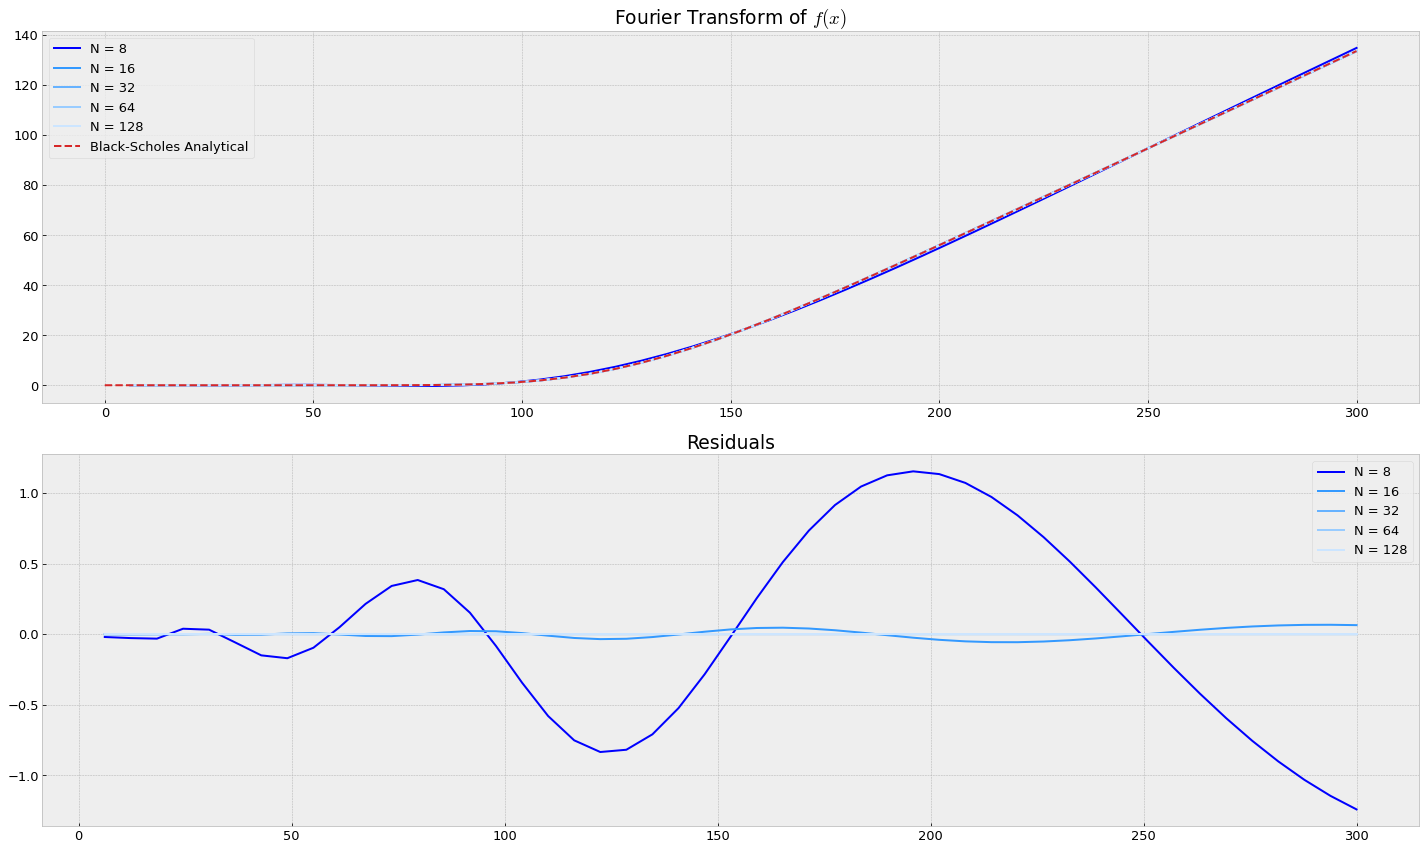

,avg_residuals,Ex. Time
N,,
8,5.075343e-01,0.000185
16,2.556765e-02,0.000179
32,5.810656e-06,0.000265
64,2.319065e-14,0.000461
128,2.319066e-14,0.000787


In [275]:
# --------------------------------------------------------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))

results = {'N': [], 'avg_residuals': [] , 'Ex. Time' : []}
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):

    ex_time = []
    Ks      = np.linspace(0,300)
    Ps_F    = []
    Ps_A    = []
    for K in Ks:
        timer =perf_counter()
        Ps_F.append( Fourier_BS_Put(S0=100, K=K, T=5, sigma=.1, r=0.05, N=N) )
        Ps_A.append( bs_put(S0=100, K=K, T=5, sigma=.1, r=0.05) )
        timer = perf_counter() - timer ; ex_time.append(timer)
    
    Ps_F, Ps_A = np.array(Ps_F), np.array(Ps_A)

    ax1.plot(Ks,Ps_F, blue_shades[i], label=f'N = {N}')
    ax2.plot(Ks,(Ps_A-Ps_F), blue_shades[i], label=f'N = {N}')
    results['N'].append(N)
    results['avg_residuals'].append(np.nanmean(np.abs(Ps_A-Ps_F)))
    results['Ex. Time'].append(np.mean(ex_time))

ax1.set_title(r'Fourier Transform of $f(x)$')
ax1.plot(Ks,Ps_A,'tab:red', linestyle='--', label='Black-Scholes Analytical')
ax2.set_title('Residuals')
plt.tight_layout() ; ax1.legend() ; ax2.legend() ; plt.show()

pd.DataFrame.from_dict(results).set_index('N')

## Importance of correct limits [a, b]

Average Absulute Error for sigma(0.05) and N(128)= 7.676799e-12
Average Absulute Error for sigma(0.05) and N(128)= 2.830925e-02
Average Absulute Error for sigma(0.2) and N(128)= 1.405853e-03


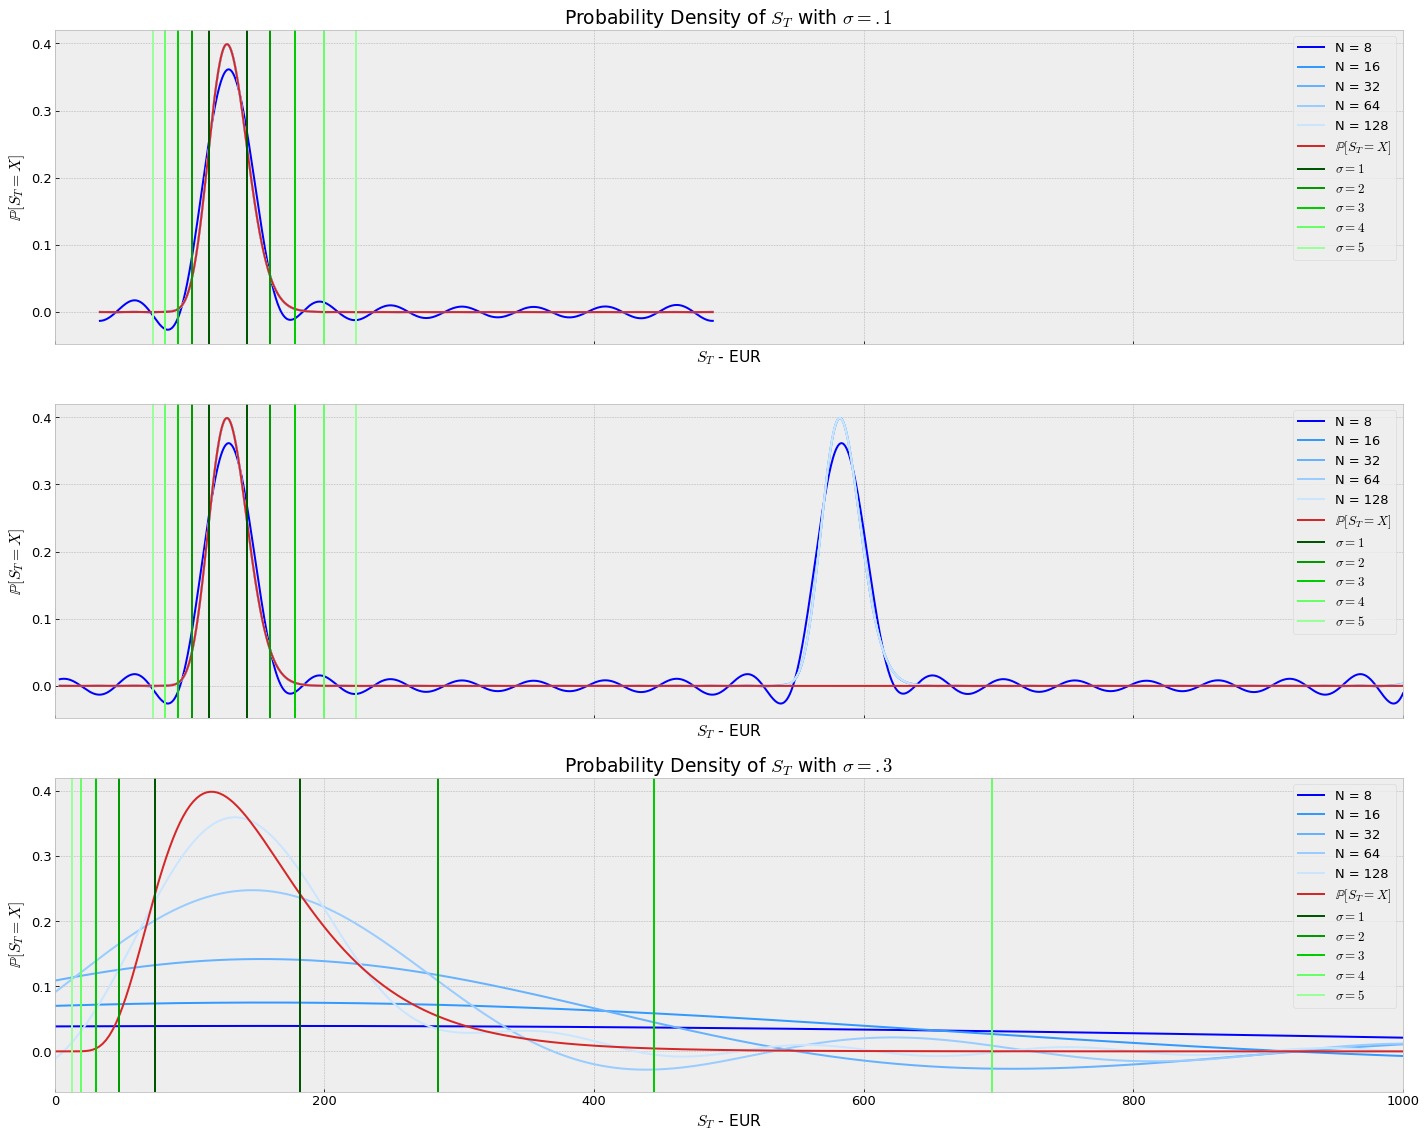

In [368]:
S0, T, r = 100, 5, .05

S_T     = lambda z : S0*exp((r-.5*sigma**2)*T + sigma*sqrt(T)*z)
S_T_inv = lambda S_T : (log(S0/S_T) + (r - .5*sigma**2)*T)/(sqrt(T)*sigma)
f       = lambda S_T : norm.pdf(S_T_inv(S_T)) # P[S_T = X]

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20,16), sharex=True)
ax1.set_title(r'Probability Density of $S_T$ with $\sigma=.1$')
#------------------------------------------------------------------------------------------------
sigma = .05
x   = np.linspace(S_T(-12), S_T(12), 10_000)
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=S_T(-12), b=S_T(12), N=N)
    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
print(f'Average Absulute Error for sigma({sigma}) and N(128)= {np.abs(fx - f(x)).mean():e}')
ax1.plot(x,f(x), label=r'$\mathbb{P}[S_T = X]$', color='tab:red')
ax1.axvline(x = S_T(1), color=green_shades[0], label = r'$\sigma = 1$')
ax1.axvline(x = S_T(-1), color=green_shades[0])
ax1.axvline(x = S_T(2), color=green_shades[1], label = r'$\sigma = 2$')
ax1.axvline(x = S_T(-2), color=green_shades[1])
ax1.axvline(x = S_T(3), color=green_shades[2], label = r'$\sigma = 3$')
ax1.axvline(x = S_T(-3), color=green_shades[2])
ax1.axvline(x = S_T(4), color=green_shades[3], label = r'$\sigma = 4$')
ax1.axvline(x = S_T(-4), color=green_shades[3])
ax1.axvline(x = S_T(5), color=green_shades[4], label = r'$\sigma = 5$')
ax1.axvline(x = S_T(-5), color=green_shades[4])
ax1.set_xlim(0,1000) ; ax1.legend()
ax1.set_xlabel(r'$S_T$ - EUR') ; ax1.set_ylabel(r'$\mathbb{P}[S_T=X]$')

#------------------------------------------------------------------------------------------------
sigma = .05
x   = np.linspace(S_T(-32), S_T(32), 10_000)
Ns = [8, 16, 32, 64, 128]
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=S_T(-12), b=S_T(12), N=N)
    ax2.plot(x,fx, blue_shades[i], label=f'N = {N}')
print(f'Average Absulute Error for sigma({sigma}) and N(128)= {np.abs(fx - f(x)).mean():e}')
ax2.plot(x,f(x), label=r'$\mathbb{P}[S_T = X]$', color='tab:red')
ax2.axvline(x = S_T(1), color=green_shades[0], label = r'$\sigma = 1$')
ax2.axvline(x = S_T(-1), color=green_shades[0])
ax2.axvline(x = S_T(2), color=green_shades[1], label = r'$\sigma = 2$')
ax2.axvline(x = S_T(-2), color=green_shades[1])
ax2.axvline(x = S_T(3), color=green_shades[2], label = r'$\sigma = 3$')
ax2.axvline(x = S_T(-3), color=green_shades[2])
ax2.axvline(x = S_T(4), color=green_shades[3], label = r'$\sigma = 4$')
ax2.axvline(x = S_T(-4), color=green_shades[3])
ax2.axvline(x = S_T(5), color=green_shades[4], label = r'$\sigma = 5$')
ax2.axvline(x = S_T(-5), color=green_shades[4])
ax2.set_xlim(0,1000) ; ax2.legend()
ax2.set_xlabel(r'$S_T$ - EUR') ; ax2.set_ylabel(r'$\mathbb{P}[S_T=X]$')

#------------------------------------------------------------------------------------------------
ax3.set_title(r'Probability Density of $S_T$ with $\sigma=.3$')
sigma = .2
x   = np.linspace(S_T(-12), S_T(12), 10_000)
for i, N in enumerate(Ns):
    fx = get_fourier_approx(f=f, x=x, a=S_T(-12), b=S_T(12), N=N)
    ax3.plot(x,fx, blue_shades[i], label=f'N = {N}')
print(f'Average Absulute Error for sigma({sigma}) and N(128)= {np.abs(fx - f(x)).mean():e}')
ax3.plot(x,f(x), label=r'$\mathbb{P}[S_T = X]$', color='tab:red')
ax3.axvline(x = S_T(1), color=green_shades[0], label = r'$\sigma = 1$')
ax3.axvline(x = S_T(-1), color=green_shades[0])
ax3.axvline(x = S_T(2), color=green_shades[1], label = r'$\sigma = 2$')
ax3.axvline(x = S_T(-2), color=green_shades[1])
ax3.axvline(x = S_T(3), color=green_shades[2], label = r'$\sigma = 3$')
ax3.axvline(x = S_T(-3), color=green_shades[2])
ax3.axvline(x = S_T(4), color=green_shades[3], label = r'$\sigma = 4$')
ax3.axvline(x = S_T(-4), color=green_shades[3])
ax3.axvline(x = S_T(5), color=green_shades[4], label = r'$\sigma = 5$')
ax3.axvline(x = S_T(-5), color=green_shades[4])
ax3.set_xlim(0,1000) ; ax3.legend()
ax3.set_xlabel(r'$S_T$ - EUR'); ax3.set_ylabel(r'$\mathbb{P}[S_T=X]$')

plt.tight_layout()

## Convergence over N

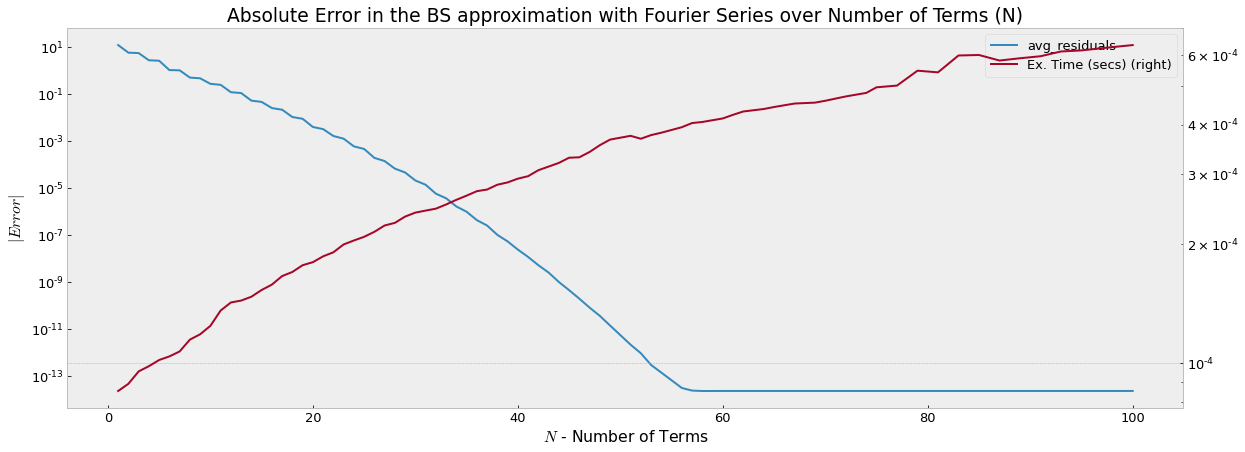

In [277]:
results = {'N': [], 'avg_residuals': [] , 'Ex. Time (secs)' : []}

Ns = np.unique(np.logspace(0, np.log10(100), num=200, base=10, dtype=int))
for i, N in enumerate(Ns):

    ex_time = []
    Ks      = np.linspace(0,300)
    Ps_F    = []
    Ps_A    = []
    for K in Ks:
        timer =perf_counter()
        Ps_F.append( Fourier_BS_Put(S0=100, K=K, T=5, sigma=.1, r=0.05, N=N) )
        Ps_A.append( bs_put(S0=100, K=K, T=5, sigma=.1, r=0.05) )
        timer = perf_counter() - timer ; ex_time.append(timer)
    
    Ps_F, Ps_A = np.array(Ps_F), np.array(Ps_A)
    results['N'].append(N)
    results['avg_residuals'].append(np.nanmean(np.abs(Ps_A-Ps_F)))
    results['Ex. Time (secs)'].append(np.mean(ex_time))

results = pd.DataFrame.from_dict(results).set_index('N')
results.plot(secondary_y='Ex. Time (secs)', logy=True, title='Absolute Error in the BS approximation with Fourier Series over Number of Terms (N)', 
    xlabel=r'$N$ - Number of Terms', ylabel=r'$|Error|$')
plt.show()
# results
    

# Error over different values

In [373]:
S0_A    = np.array([100])
K_A     = np.linspace(0,    500,    25)
T_A     = np.linspace(0,    30,     25)
r_A     = np.linspace(-.03, 0.20,   25)
sigma_A = np.linspace(.05,  1,      25)

grid = np.stack(np.meshgrid(S0_A, K_A, T_A, r_A, sigma_A), axis=-1).reshape(-1, 5)

results = {'S0': [], 'K': [], 'T': [], 'r': [], 'sigma': [], 'Fourier Series': [], 'Analytical': []}
for S0, K, T, r, sigma in tqdm(grid):
    results['S0'].append(S0) ; results['K'].append(K) ; results['T'].append(T) ; results['r'].append(r) ; results['sigma'].append(sigma)
    results['Fourier Series'].append( Fourier_BS_Put(S0=S0, K=K, T=T, sigma=sigma, r=r, N=128) )
    results['Analytical'].append( bs_put(S0=S0, K=K, T=T, sigma=sigma, r=r) )
    
results_df = pd.DataFrame.from_dict(results)
results_df = results_df[~results_df['Fourier Series'].isnull()]
results_df['Error'] = abs(results_df['Fourier Series'] - results_df['Analytical'])
results_df['RE'] = abs(results_df['Fourier Series'] - results_df['Analytical'])/results_df['Analytical']

print(f'>>Mean Error: {results_df.Error.mean()}')
results_df.sort_values('Error', ascending=False).head(10)

100%|██████████| 390625/390625 [05:14<00:00, 1243.62it/s]


>>Mean Error: 0.0028921838547530435
>>Mean RE   : 1.4228109978759102e+212


,S0,K,T,r,sigma,Fourier Series,Analytical,Error,RE
375249,100.000,500.000,0.000,0.056,1.000,399.637,400.000,0.363,0.001
375274,100.000,500.000,0.000,0.066,1.000,399.637,400.000,0.363,0.001
375224,100.000,500.000,0.000,0.047,1.000,399.640,400.000,0.360,0.001
375299,100.000,500.000,0.000,0.075,1.000,399.642,400.000,0.358,0.001
359574,100.000,479.167,0.000,0.037,1.000,378.811,379.167,0.356,0.001
359599,100.000,479.167,0.000,0.047,1.000,378.812,379.167,0.354,0.001
375199,100.000,500.000,0.000,0.037,1.000,399.646,400.000,0.354,0.001
359549,100.000,479.167,0.000,0.028,1.000,378.813,379.167,0.354,0.001
375324,100.000,500.000,0.000,0.085,1.000,399.649,400.000,0.351,0.001
359624,100.000,479.167,0.000,0.056,1.000,378.817,379.167,0.349,0.001


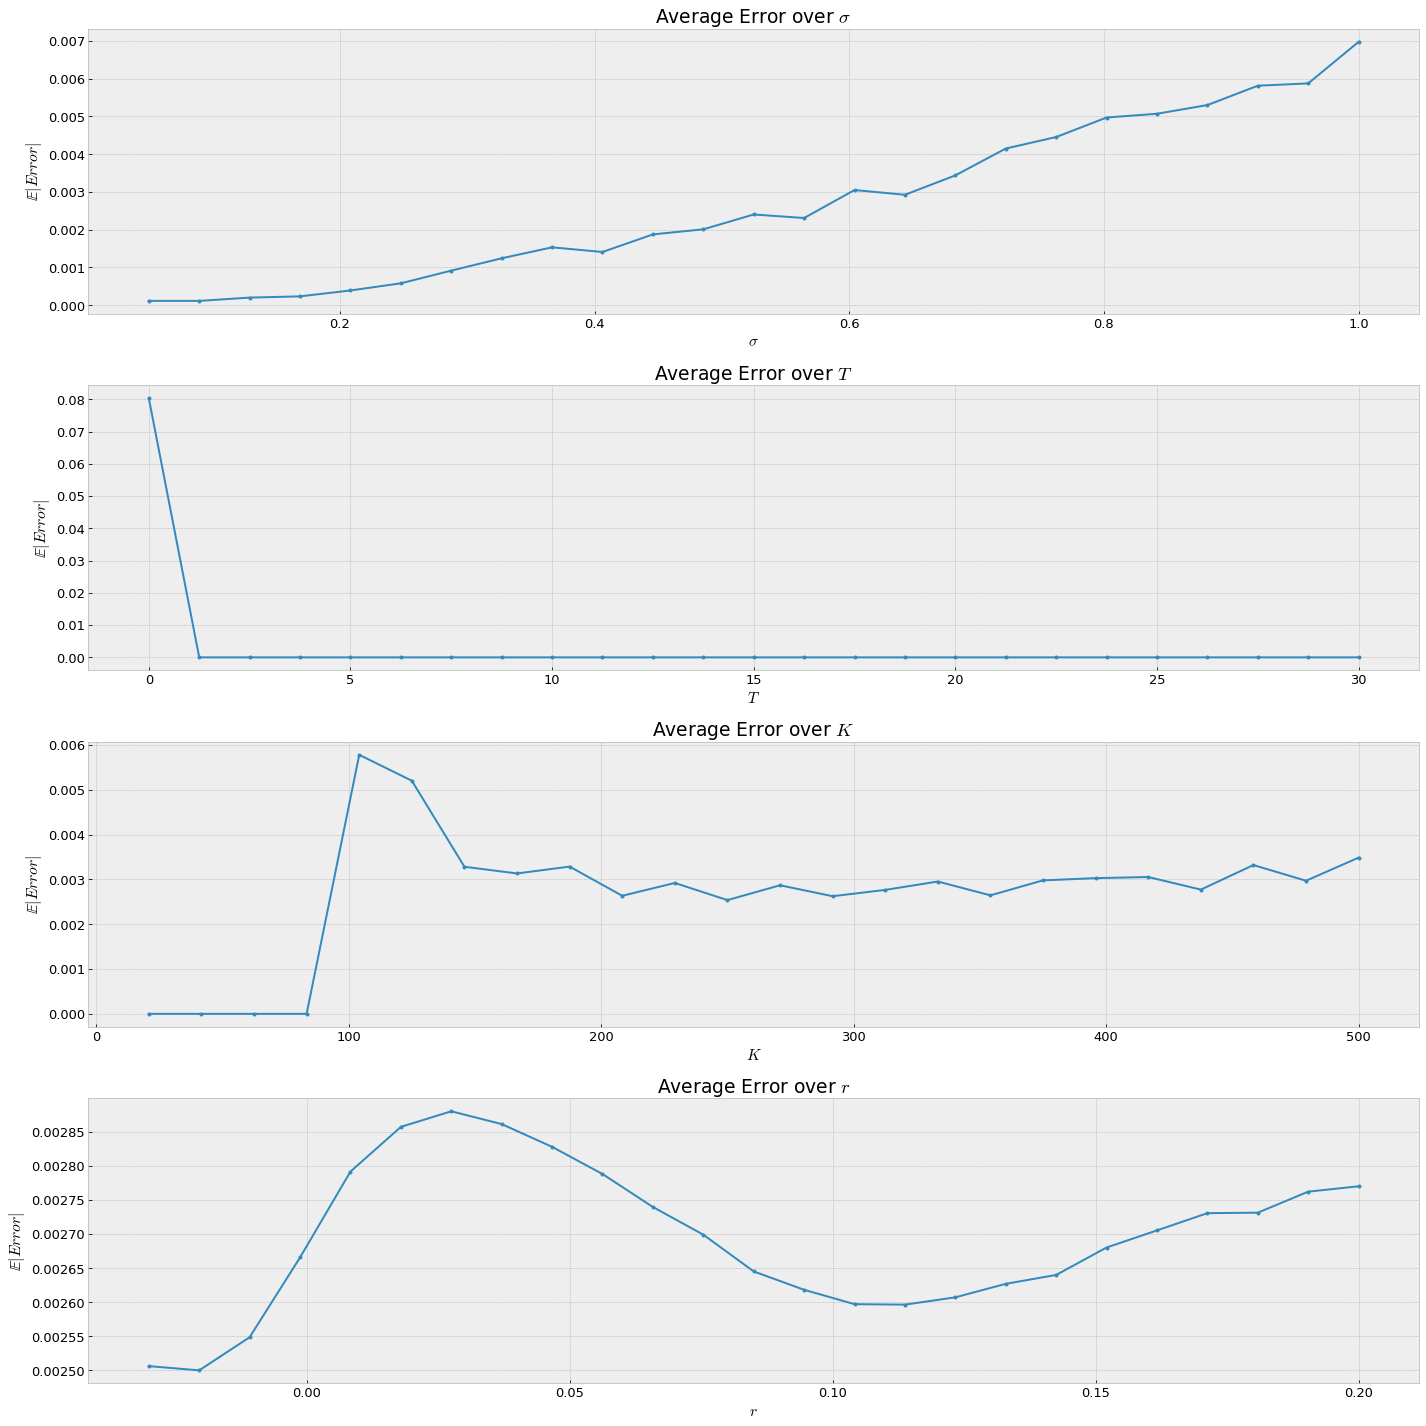

In [388]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(20,20))
results_df.groupby('sigma')['Error'].mean().plot(ax=ax1, title=r'Average Error over $\sigma$', xlabel=r'$\sigma$', ylabel=r'$\mathbb{E}|Error|$', marker='.')
results_df.groupby('T')['Error'].mean().plot(ax=ax2, title=r'Average Error over $T$', xlabel=r'$T$', ylabel=r'$\mathbb{E}|Error|$', marker='.')
results_df.groupby('K')['Error'].mean().plot(ax=ax3, title=r'Average Error over $K$', xlabel=r'$K$', ylabel=r'$\mathbb{E}|Error|$', marker='.')
results_df.groupby('r')['Error'].mean().plot(ax=ax4, title=r'Average Error over $r$', xlabel=r'$r$', ylabel=r'$\mathbb{E}|Error|$', marker='.')

plt.tight_layout()

# Part 3

In [ ]:
def Fourier_Heston_Put(**args):
    # print(args)
    a = log(args['S0']/args['K']) + args['r'] * args['T'] - z_score * sqrt(args['sigma']**2 * args['T']) # Upper limit -12 std from the expected value
    b = log(args['S0']/args['K']) + args['r'] * args['T'] + args['z_score'] * sqrt(args['sigma']**2 * args['T']) # Lower limit -12 std from the expected value

    # print(a,b)

    h       = lambda n : (n*pi) / (b-a) 
    g       = lambda n : (exp(a) - (args['K']/h(n))*sin(h(n)*(a - log(args['K']))) - K*cos(h(n)*(a - log(args['K'])))) / (1 + h(n)**2)
    g0      = K*(log(args['K']) - a - 1) + exp(a)
    
    

    def heston_char(u, **args): 
        print(args)
        # heston variables
        kappa   = args['kappa']
        theta   = args['theta']
        rho     = args['rho']
        zeta    = args['zeta']
        vt      = args['vt']

        d = sqrt((rho*zeta*1j*u - kappa)**2 + zeta**2*(1j*u + u**2))
        c = (kappa - rho*zeta*1j*u - d)/(kappa - rho*zeta*1j*u + d)
        beta = ( (kappa - rho*zeta*1j*u -d)*(1 - exp(-d*T)) )/(zeta**2*(1-c*exp(-d*T)))
        alpha = (kappa*theta)/zeta**2 *((kappa - rho*zeta*1j - d)*T - 2*log((1-c*exp(-d*T))/(1-c)))
        m  = log(args['S0']) + (args['r'])*(args['T'])
        
        return exp(1j*u*m +alpha + beta*vt)

    F = g0 
    for n in range(1, N+1):
        h_n = h(n)
        F += 2*heston_char(h_n, args=args) * exp(-1j*a*h_n) * g(n)

    F = exp((-args['r']*T)/(b-a))/(b-a) * np.real(F)
    return F

In [ ]:
args = {
'S0'      : 100.0 ,
'K'       : 100.0 ,
'r'       : 0.0 ,
'sigma'   : 0.1 ,
'T'       : 5.0 ,
'z_score' : 32, 

'kappa'   : .1 ,
'theta'   : .1 ,
'rho'     : .1 ,
'zeta'    : .1 ,
'vt'      : .1 ,
}

fig, (ax1, ax2) = plt.subplots(2, figsize=(20,12))
df = {'N' : Ns, 'avg_residuals' : [], 'Ex. Time' : []}
for i, N in enumerate(Ns):
    args['N']   = 32
    Ks          = np.linspace(0,300, 100)[1:]

    results     = {
        'K'                 : Ks, 
        'Price Fourier'     : [],
        'Price Analytical'  : []
        }
    for idx, K in enumerate(results['K']):
        args['K'] = K
        results['Price Fourier'].append( Fourier_Heston_Put(**args) )
        results['Price Analytical'].append( bs_put(S0=args['S0'], K=args['K'], T=args['T'], sigma=args['sigma'], r=args['r']) )
    
    x   = Ks
    fx  = np.array(results['Price Fourier'])
    y   = np.array(results['Price Analytical'])
    
    df['avg_residuals'].append(np.mean(np.abs((y-fx))))

    #Timings
    timmings = np.empty(300)
    for it in range(300):
        timer = perf_counter()
        _ = Fourier_BS_Put(**args)
        timmings[it] = perf_counter() - timer
    df['Ex. Time'].append(np.mean(timmings))

    ax1.plot(x,fx, blue_shades[i], label=f'N = {N}')
    ax2.plot(x,(y-fx), blue_shades[i], label=f'N = {N}')

ax1.plot(x,y, 'r--', label=f'Analytical')
ax1.set_title(r'Put Option price at $t=0$ over $K$ - Using Fourier Series')
ax1.set_xlabel(r'K - EUR') ; ax1.set_ylabel(r'$P_0$ - EUR')

ax2.set_title(r'Residuals ')
ax2.set_xlabel(r'K - EUR') ; ax2.set_ylabel(r'$P_0$ - EUR')
plt.tight_layout() ; ax1.legend() ; ax2.legend()
plt.plot()

pd.DataFrame.from_dict(df).set_index('N')
# df

In [ ]:
def COS_method_val(S0, K, T, sigma, r, N):
    a = log(S0/K) + r * T - 12 * sqrt(sigma**2 * T) # Upper limit -12 std from the expected value
    b = log(S0/K) + r * T + 12 * sqrt(sigma**2 * T) # Lower limit -12 std from the expected value
    x = log(S0/K)
    d = b
    c = 0

    pi_daba = pi * ((d - a)/(b - a))
    pi_caba = pi * ((c - a)/(b - a))
    pi_xaba = pi * ((x - a)/(b - a))
    ed = exp(d)
    ec = exp(c)

    # Calculate the value of the call option
    V = 0
    for k in range(N + 1):
        k_pi_ba = (k * pi)/(b - a)

        #Characteristic function of simple BS
        bs_char = np.real(
            exp(1j*k_pi_ba * (r - 0.5 * sigma **2) * T -(0.5 * sigma**2 * T * k_pi_ba**2)) 
            * exp(1j * k * pi_xaba) 
            )

        # chi and psi
        chi = (1/(1 + (k_pi_ba)**2)) * (cos(k * pi_daba) * ed - cos(k * pi_caba) \
            + k_pi_ba * (sin(k * pi_daba) * ed - sin(k * pi_caba)))
        if k == 0:
            psi = d - c
        else:
            psi = (b - a)/(k * pi) * (sin(k * pi_daba) - sin(k * pi_caba))

        # payoff function and conditional density function with cosine coefficients
        Gk = 2/(b - a) * K * (chi - psi)
        Fk = 2/(b - a) * bs_char
        if k == 0:
            Fk *= 0.5

        V += Fk * Gk

    V = exp((-r * T) * ((b - a) / 2) ) * V
    return V

# %timeit 
COS_method_val(S0, K, T, sigma, r, 64)

22.561147343372014